In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
base_skin_dir = 'data'
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers. normalization import BatchNormalization
import keras
from keras.utils.np_utils import to_categorical

from PIL import Image

batch_size = 128
num_classes = 10
epochs = 5

In [2]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df = tile_df.sample(1000)
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
#tile_df.sample(500)

In [4]:
tile_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,1000,1000,1000,1000,1000,1000,1000,1000
unique,972,1000,7,4,3,15,1000,7
top,HAM_0001863,ISIC_0026736,nv,histo,male,back,data/HAM10000_images_part_2/ISIC_0030484.jpg,Melanocytic nevi
freq,3,1,684,521,521,212,1,684


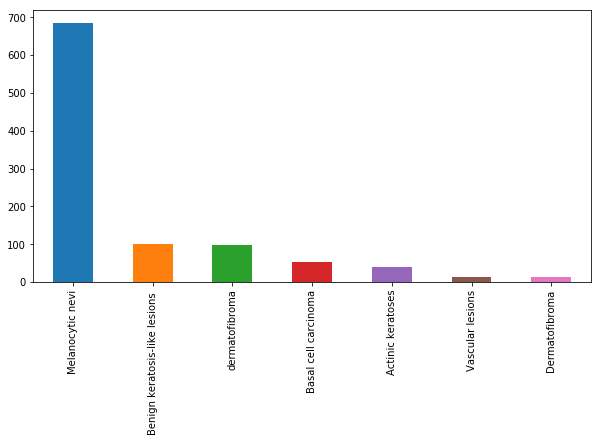

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)


In [7]:
# load in all of the images
from skimage.io import imread
#tile_df['image'] = tile_df['path'].map(imread)
#tile_df['image'] = np.array(tile_df['image']) #np.array(img)

tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((225,300))))       

In [5]:
# see the image size distribution
tile_df['image'].map(lambda x: x.shape).value_counts()

(45, 60, 3)    1000
Name: image, dtype: int64

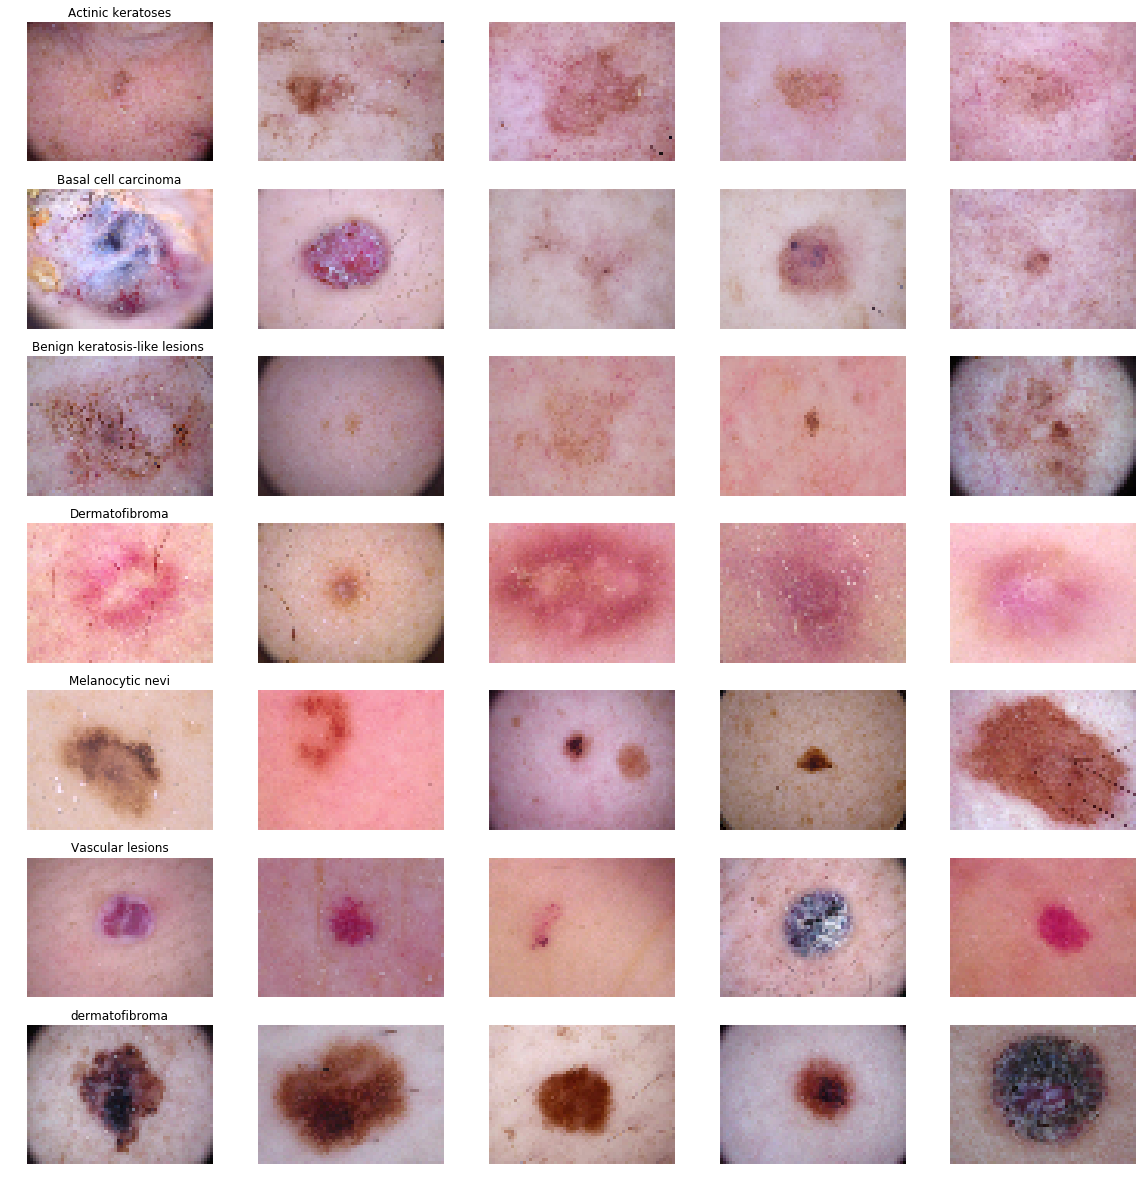

In [6]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [8]:
def load_data(tile_df):
    train_set, test_set = train_test_split(tile_df, test_size = 0.25, random_state = 42)
    
    x_train, y_train = train_set['image'], train_set['dx']
    x_test, y_test = train_set['image'], train_set['dx']
    
    return (x_train, y_train), (x_test, y_test)

In [8]:
tile_df.to_csv('trial_train.csv')
tile_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx', 'image'],
      dtype='object')

In [9]:
train, test = load_data(tile_df)

#train_data = np.array([i[0] for i in train]).reshape(-1, 450, 600, 3)

#[print(i[1]) for i in train]
#type(train[1][1, 1])

In [24]:
y = tile_df.cell_type_idx

from sklearn.model_selection import train_test_split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(tile_df, y, test_size=0.25)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [26]:
input_shape = (90, 120,  3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(90, 120,  3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(7, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 448, 598, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 224, 299, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 299, 32)      128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 297, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 148, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 111, 148, 64)      256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 109, 146, 96)      55392     
__________

In [27]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

batch_size = 32 # Todo: experiment with this variable more
epochs = 12

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 750 samples, validate on 250 samples
Epoch 1/12
750/750 [==============================] - 33s 44ms/step - loss: 5.3463 - acc: 0.6360 - val_loss: 5.4157 - val_acc: 0.6640
Epoch 2/12
750/750 [==============================] - 31s 42ms/step - loss: 5.4372 - acc: 0.6627 - val_loss: 5.4157 - val_acc: 0.6640
Epoch 3/12
750/750 [==============================] - 31s 41ms/step - loss: 5.4372 - acc: 0.6627 - val_loss: 5.4157 - val_acc: 0.6640
Epoch 4/12
750/750 [==============================] - 31s 41ms/step - loss: 5.3843 - acc: 0.6587 - val_loss: 2.3750 - val_acc: 0.6640
Epoch 5/12
750/750 [==============================] - 31s 41ms/step - loss: 1.3741 - acc: 0.6080 - val_loss: 1.1309 - val_acc: 0.6640
Epoch 6/12
750/750 [==============================] - 31s 41ms/step - loss: 1.0035 - acc: 0.6653 - val_loss: 1.0222 - val_acc: 0.6640
Epoch 7/12
750/750 [==============================] - 31s 41ms/step - loss: 0.9030 - acc: 0.6787 - val_loss: 0.9899 - val_acc: 0.6320
Epoch 8/12
750/7

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800)

In [ ]:
train_batch_size = 64
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch